<a href="https://colab.research.google.com/github/pedroafleite/crypto-risk-assessment/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install quandl

In [90]:
import quandl as qd
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.simplefilter("ignore")

In [110]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# **Bitcoin**

In [91]:
KEY = ""
qd.ApiConfig.api_key = KEY
bitcoin = qd.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc[(bitcoin !=0).any(1)]

In [92]:
bitcoin = bitcoin.reset_index()
bitcoin.head()

,Date,Value
0,2010-08-16,0.0769
1,2010-08-18,0.0688
2,2010-08-19,0.0667
3,2010-08-20,0.0700
4,2010-08-21,0.0664


In [93]:
bitcoin["log_y"] = np.log(bitcoin["Value"])

In [94]:
bitcoin = bitcoin.rename(columns={"Date": "ds", "log_y" : "y"})
bitcoin.head()

,ds,Value,y
0,2010-08-16,0.0769,-2.565249
1,2010-08-18,0.0688,-2.676552
2,2010-08-19,0.0667,-2.707550
3,2010-08-20,0.0700,-2.659260
4,2010-08-21,0.0664,-2.712058


In [95]:
priors = [0.005, 0.05]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(bitcoin)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [96]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [97]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.005_ds", right_on = "0.05_ds")
output = output.rename(columns={"0.005_ds": "Date"}).drop("0.05_ds", axis=1)

In [98]:
output = output.set_index('Date')
output.head()

,trend_x,yhat_lower_x,yhat_upper_x,trend_lower_x,trend_upper_x,additive_terms_x,additive_terms_lower_x,additive_terms_upper_x,weekly_x,weekly_lower_x,weekly_upper_x,yearly_x,yearly_lower_x,yearly_upper_x,multiplicative_terms_x,multiplicative_terms_lower_x,multiplicative_terms_upper_x,yhat_x,trend_y,yhat_lower_y,yhat_upper_y,trend_lower_y,trend_upper_y,additive_terms_y,additive_terms_lower_y,additive_terms_upper_y,weekly_y,weekly_lower_y,weekly_upper_y,yearly_y,yearly_lower_y,yearly_upper_y,multiplicative_terms_y,multiplicative_terms_lower_y,multiplicative_terms_upper_y,yhat_y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-16,-1.267827,-2.041972,-0.383263,-1.267827,-1.267827,0.052723,0.052723,0.052723,-0.002437,-0.002437,-0.002437,0.055160,0.055160,0.055160,0.0,0.0,0.0,-1.215104,-3.059324,-3.430285,-2.524836,-3.059324,-3.059324,0.073896,0.073896,0.073896,-0.000523,-0.000523,-0.000523,0.074419,0.074419,0.074419,0.0,0.0,0.0,-2.985427
2010-08-18,-1.256455,-2.084745,-0.418038,-1.256455,-1.256455,0.030570,0.030570,0.030570,-0.000422,-0.000422,-0.000422,0.030993,0.030993,0.030993,0.0,0.0,0.0,-1.225885,-3.026794,-3.421325,-2.507900,-3.026794,-3.026794,0.067165,0.067165,0.067165,0.000464,0.000464,0.000464,0.066701,0.066701,0.066701,0.0,0.0,0.0,-2.959629
2010-08-19,-1.250769,-2.122311,-0.438893,-1.250769,-1.250769,0.020715,0.020715,0.020715,0.001841,0.001841,0.001841,0.018874,0.018874,0.018874,0.0,0.0,0.0,-1.230055,-3.010529,-3.352337,-2.540568,-3.010529,-3.010529,0.064790,0.064790,0.064790,0.002216,0.002216,0.002216,0.062574,0.062574,0.062574,0.0,0.0,0.0,-2.945739
2010-08-20,-1.245083,-2.057591,-0.409142,-1.245083,-1.245083,0.006153,0.006153,0.006153,-0.000696,-0.000696,-0.000696,0.006848,0.006848,0.006848,0.0,0.0,0.0,-1.238931,-2.994264,-3.343123,-2.510235,-2.994264,-2.994264,0.057422,0.057422,0.057422,-0.000833,-0.000833,-0.000833,0.058255,0.058255,0.058255,0.0,0.0,0.0,-2.936842
2010-08-21,-1.239398,-2.059062,-0.422878,-1.239398,-1.239398,-0.005784,-0.005784,-0.005784,-0.000783,-0.000783,-0.000783,-0.005002,-0.005002,-0.005002,0.0,0.0,0.0,-1.245182,-2.977999,-3.369033,-2.525256,-2.977999,-2.977999,0.052319,0.052319,0.052319,-0.001416,-0.001416,-0.001416,0.053735,0.053735,0.053735,0.0,0.0,0.0,-2.925680


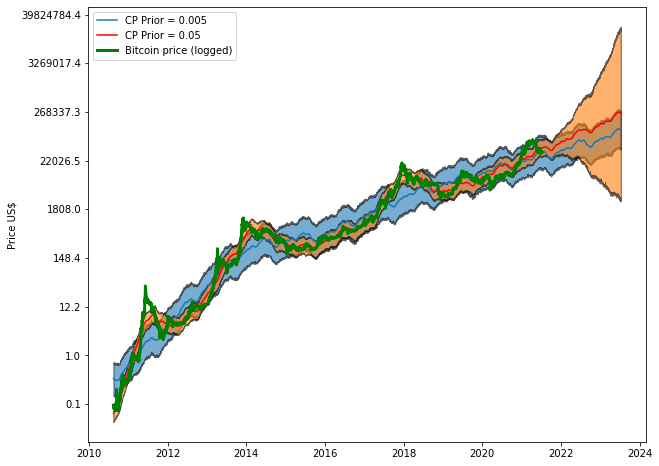

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(bitcoin.ds, bitcoin.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [161]:
bitcoin.tail()

,ds,Value,y
3976,2021-07-06,33747.97,10.426676
3977,2021-07-07,34211.01,10.440303
3978,2021-07-08,33839.04,10.429370
3979,2021-07-09,32877.41,10.400541
3980,2021-07-10,33818.52,10.428764


In [250]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

configure_plotly_browser_state()
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.scatter(bitcoin, x='ds', y='y', hover_data=['Value'])
fig.add_trace(go.Scatter(x=output.index, y=output.yhat_upper_x,
    fill=None,
    opacity=0.5,
    mode='lines',
    line_color='blue'
    ))
fig.add_trace(go.Scatter(x=output.index, y=output.yhat_lower_x,
    fill='tonexty', opacity=0.5, # fill area between trace0 and trace1
    mode='lines', line_color='blue'))
fig.add_trace(go.Scatter(x=output.index, y=output.yhat_upper_y,
    fill=None,
    opacity=0.5,
    mode='lines',
    line_color='red'
    ))
fig.add_trace(go.Scatter(x=output.index, y=output.yhat_lower_y,
    fill='tonexty', opacity=0.5, # fill area between trace0 and trace1
    mode='lines', line_color='red'))
fig.update_layout(hovermode="x")
fig.show()

In [150]:
import plotly.graph_objects as go
configure_plotly_browser_state()
fig = go.Figure([go.Scatter(x=bitcoin.ds, y=bitcoin.Value, line=dict(color='#008000'))])
fig.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# calculate MAE between expected and predicted values for June
y_true = bitcoin['y'].values
y_pred = output['trend_x'][-3981:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# **Ethereum**

In [ ]:
KEY = ""
qd.ApiConfig.api_key = KEY
eth = qd.get("BITFINEX/ETHUSD")
eth = eth.loc[(eth !=0).any(1)]

In [ ]:
eth = eth.reset_index()
eth.head()

In [ ]:
eth["log_y"] = np.log(eth["Last"])
eth = eth.rename(columns={"Date": "ds", "log_y" : "y"})
eth.head()

In [ ]:
priors = [0.0005, 0.005]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(eth)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

In [ ]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [ ]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0005_ds", right_on = "0.005_ds")
output = output.rename(columns={"0.0005_ds": "Date"}).drop("0.005_ds", axis=1)
output = output.set_index('Date')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(eth.ds, eth.y, color="green", linewidth=3, label=r"Ether price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [ ]:
# calculate MAE between expected and predicted values for June
y_true = eth['y'].values
y_pred = output['trend_x'][-1902:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# **ETH/BTC**

In [ ]:
KEY = ""
qd.ApiConfig.api_key = KEY
ethbtc = qd.get("BITFINEX/ETHBTC")
ethbtc = ethbtc.loc[(ethbtc !=0).any(1)]

In [ ]:
ethbtc = ethbtc.reset_index()
ethbtc.head()

In [ ]:
ethbtc["log_y"] = np.log(ethbtc["Last"])
ethbtc = ethbtc.rename(columns={"Date": "ds", "log_y" : "y"})
ethbtc.head()

In [ ]:
priors = [0.0015, 0.015]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(ethbtc)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
output = output.set_index('Date')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(ethbtc.ds, ethbtc.y, color="green", linewidth=3, label=r"Eth/btc price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Ratio")
plt.show()

In [ ]:
# calculate MAE between expected and predicted values for June
y_true = ethbtc['y'].values
y_pred = output['trend_x'][-1901:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
!pip install pandas-datareader

In [ ]:
import pandas_datareader.data as pdr
import datetime as dt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
names = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', '50SMA', '350SMA', 'R']
start = dt.datetime(2017,9,20)
end = dt.datetime(2021,6,9)
df = pdr.DataReader('LINK-USD','yahoo',start,end)

df['50SMA'] = df.Close.rolling(window=50).mean()
df['350SMA'] = df.Close.rolling(window=350).mean()
df['R'] = df['50SMA']/df['350SMA']
df['R'].plot();